In [1]:
import os
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
os.chdir('/home/diego/Documentos/IDEAM/IDEAM_ETo/')

In [2]:
# Abro el archivo nc
nc_name = 'Salida_d02_radocsfc_1996-2015.nc'  # Nombre del archivo
ncfile = Dataset(nc_name) #importa archivo netcdf

In [3]:
# Imprimo las variables y su información
for i in ncfile.variables:
    print('------------------------------------------------')
    print(i)
    try:
        print(ncfile.variables[i].units)
        print(ncfile.variables[i].coordinates)
    except AttributeError:
        continue

------------------------------------------------
lon
degrees_east
------------------------------------------------
lat
degrees_north
------------------------------------------------
time
minutes since 1996-01-01 09:00:00
------------------------------------------------
radocsfc


In [4]:
# Creo objeto que almacene las fechas
ncfile.variables['time']
fechas = [datetime(1996, 1, 1, 9) + timedelta(days=i/(60*24)) 
          for i in ncfile.variables['time'][:]]

In [5]:
mes = [i.month for i in fechas] # Objeto con el mes 
anno = [i.year for i in fechas] # Objeto con el año

prom_annos = defaultdict()  # Objeto que almacenará todas las matrices
sum_annos = defaultdict()
for anno_it in range(1996, 2016):   # Itero en los años para hacer el cálculo
    prom_anno = defaultdict()
    sum_anno = defaultdict()
    for mes_it in range(1, 13):  # Itero en los meses
        matriz_mes = []
        index = 0
        for i, j in zip(mes, anno):
            if i == mes_it and j == anno_it:
                matriz_mes.append(ncfile['radocsfc'][index])
            index += 1
        prom_anno[mes_it] = np.mean(matriz_mes, axis=0) # Promedio
        sum_anno[mes_it] = np.sum(matriz_mes, axis=0) # Suma
    prom_annos[anno_it] = prom_anno  # promedio mensual
    sum_annos[anno_it] = sum_anno  # total mensual

In [25]:
suma_anno_total = defaultdict()
for anno in sum_annos.keys():
    sum_temp = []
    for mes in range(1, 13):
        sum_temp.append(sum_annos[anno][mes])
    sum_temp = np.array(sum_temp)
    suma_anno_total[anno] = np.sum(sum_temp, axis=0)
    
prom_meses = defaultdict()

for mes in range(1, 13):
    prom_temp = []
    for anno in sum_annos.keys():
        prom_temp.append(sum_annos[anno][mes])
    prom_temp = np.array(prom_temp)
    prom_meses[mes] = np.mean(prom_temp, axis = 0)

In [32]:
#Crear los raster para la suma año

for anno in suma_anno_total.keys():
    array = suma_anno_total[anno] # W/m2

    xmin,ymin,xmax,ymax = [min(ncfile.variables['lon'][:] - 360), min(ncfile.variables['lat'][:]),
                           max(ncfile.variables['lon'][:] - 360), max(ncfile.variables['lat'][:])]
    nrows,ncols = np.shape(array)
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform=(xmin, xres,0,ymin,0, yres)
    raster_path = '/home/diego/Documentos/IDEAM/IDEAM_ETo/Suma_Anno/' # Carpeta para guardar rasters
    raster_name = '%d_sum_W.tif' % (anno) # nombre del raster
    output_raster = gdal.GetDriverByName('GTiff').Create(raster_path + raster_name
                                                         ,ncols, nrows, 1 ,gdal.GDT_Float32)
    output_raster.GetRasterBand(1).WriteArray( array ) 
    output_raster.SetGeoTransform(geotransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326) #British National Grid OSGB1936
    output_raster.SetProjection(srs.ExportToWkt())
    output_raster = None

In [34]:
#Crear los raster para promedio meses

for mes in prom_meses.keys():
    array = prom_meses[mes] # W/m2

    xmin,ymin,xmax,ymax = [min(ncfile.variables['lon'][:] - 360), min(ncfile.variables['lat'][:]),
                           max(ncfile.variables['lon'][:] - 360), max(ncfile.variables['lat'][:])]
    nrows,ncols = np.shape(array)
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform=(xmin, xres,0,ymin,0, yres)
    raster_path = '/home/diego/Documentos/IDEAM/IDEAM_ETo/Prom_Mes/' # Carpeta para guardar rasters
    raster_name = '%d_prom_W.tif' % (mes) # nombre del raster
    output_raster = gdal.GetDriverByName('GTiff').Create(raster_path + raster_name
                                                         ,ncols, nrows, 1 ,gdal.GDT_Float32)
    output_raster.GetRasterBand(1).WriteArray( array ) 
    output_raster.SetGeoTransform(geotransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326) #British National Grid OSGB1936
    output_raster.SetProjection(srs.ExportToWkt())
    output_raster = None

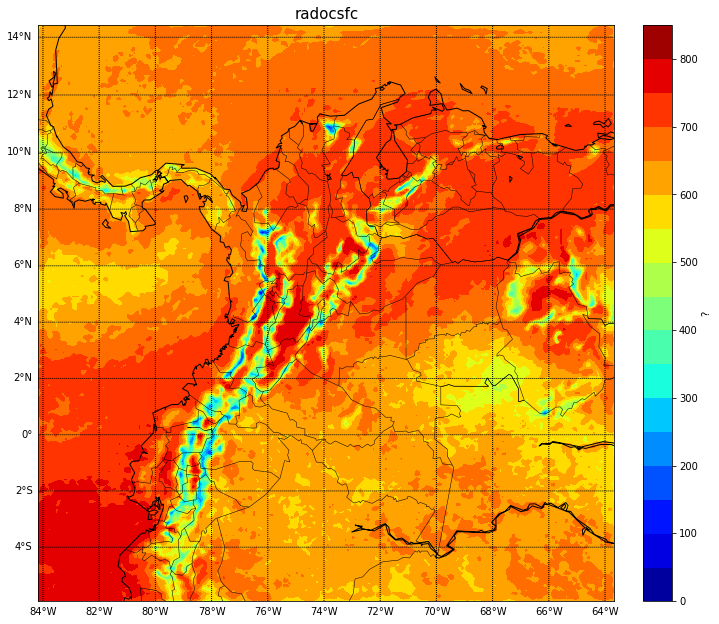

In [6]:
# Mapa de Ejemplo
data = sum_annos[1996][2] * 3600 * 12 / 1e6
fig = plt.figure(figsize=(11,11))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='merc',lon_0=-74.1,lat_0=4.63,lat_ts=4.63,\
            llcrnrlat=ncfile['lat'][:][0],urcrnrlat=ncfile['lat'][:][-1],\
            llcrnrlon=ncfile['lon'][:][0],urcrnrlon=ncfile['lon'][:][-1],\
            rsphere=6371200.,resolution='l',area_thresh=100)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# draw parallels.
parallels = np.arange(-90.,90,2.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,2.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.

# draw filled contours.
clevs = np.arange(0, 851, 50)
cs = m.contourf(x,y,data,clevs,cmap='jet')
# add colorbar.
cbar = m.colorbar(cs,location='right',pad="5%")
cbar.set_label('?')
# add title
plt.title('radocsfc', 
         fontsize=15)
plt.show()

In [6]:
#Crear los raster para la suma

for anno in sum_annos.keys():
    for mes in sum_annos[anno].keys():
        array = sum_annos[anno][mes] # W/m2

        xmin,ymin,xmax,ymax = [min(ncfile.variables['lon'][:] - 360), min(ncfile.variables['lat'][:]),
                               max(ncfile.variables['lon'][:] - 360), max(ncfile.variables['lat'][:])]
        nrows,ncols = np.shape(array)
        xres = (xmax-xmin)/float(ncols)
        yres = (ymax-ymin)/float(nrows)
        geotransform=(xmin, xres,0,ymin,0, yres)
        raster_path = '/home/diego/Documentos/IDEAM/IDEAM_ETo/Rasters/' # Carpeta para guardar rasters
        raster_name = '%d_%d_sum_W.tif' % (anno, mes) # nombre del raster
        output_raster = gdal.GetDriverByName('GTiff').Create(raster_path + raster_name
                                                             ,ncols, nrows, 1 ,gdal.GDT_Float32)
        output_raster.GetRasterBand(1).WriteArray( array ) 
        output_raster.SetGeoTransform(geotransform)
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326) #British National Grid OSGB1936
        output_raster.SetProjection(srs.ExportToWkt())
        output_raster = None
